In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
std_win = 90 # moving window for standard deviation
ma_win = 20 # moving window for the mean
starts = np.arange(2005,2019) # start years
length = 3 # 3 year periods
tc = 0.001 # 0.1% two-way transaction cost
all_cumret = {}
all_cumret_tc = {}
market_cumret = {}
num_stocks = {}

In [3]:
for start in starts:
    # set start and end dates
    start_date = f'{start}-01-01'
    end_date = f'{start+length-1}-12-31'
    # prepare data
    prices_open = pd.read_csv('vbr99_21_open.csv', index_col=0)
    prices_high = pd.read_csv('vbr99_21_high.csv', index_col=0)
    prices_low = pd.read_csv('vbr99_21_low.csv', index_col=0)
    prices_close = pd.read_csv('vbr99_21_close.csv', index_col=0)
    volume = pd.read_csv('vbr99_21_volume.csv', index_col=0)
    prices_open = prices_open.loc[start_date:end_date].dropna(axis=1)
    prices_high = prices_high.loc[start_date:end_date].dropna(axis=1)
    prices_low = prices_low.loc[start_date:end_date].dropna(axis=1)
    prices_close = prices_close.loc[start_date:end_date].dropna(axis=1)
    volume = volume.loc[start_date:end_date].dropna(axis=1)
    
    # drop stocks with volume<1000 at any trading day
    low_vol = (volume<1000).sum()
    low_vol_symbols = low_vol[low_vol!=0].index
    prices_open.drop(low_vol_symbols, axis=1, inplace=True)
    prices_high.drop(low_vol_symbols, axis=1, inplace=True)
    prices_low.drop(low_vol_symbols, axis=1, inplace=True)
    prices_close.drop(low_vol_symbols, axis=1, inplace=True)
    
    num_stocks[start] = len(prices_open.columns)
    
    # calculate returns
    returns_close = prices_close.pct_change().dropna() # daily close-to-close returns
    returns_low_open = prices_open / prices_low.shift() - 1 # today open over previous day close
    returns_open_close = prices_close / prices_open - 1 # today close over today open
    # calculate moving average and moving std
    ret_close_std = returns_close.rolling(std_win).std()
    prices_close_ma = prices_close.rolling(ma_win).mean()
    # drop NA and align indexes
    ret_close_std = ret_close_std.dropna()
    prices_close_ma = prices_close_ma.loc[ret_close_std.index]
    returns_close = returns_close.loc[ret_close_std.index]
    returns_low_open = returns_low_open.loc[ret_close_std.index]
    returns_open_close = returns_open_close.loc[ret_close_std.index]
    prices_open = prices_open.loc[ret_close_std.index]
    
    # find stocks satisfying required conditions
    candidates = ((returns_low_open < ret_close_std) & (prices_open > prices_close_ma))
    # prepare dataframe for storing strategy returns
    algo_returns = pd.DataFrame(index=candidates.index, columns=['return'])
    
    # backtest
    for t in candidates.index:
        # stocks satisfying required conditions
        candidates_today = candidates.loc[t][candidates.loc[t]==1].index
        # up to 10 stocks chosen for trading
        symbols = returns_low_open.loc[t][candidates_today].sort_values().index[:10]
        # end of day returns
        ret = returns_open_close.loc[t][symbols].sum() / len(symbols)
        algo_returns.loc[t]['return'] = ret
        
    # calculate cumulative returns   
    all_cumret[start] = (algo_returns+1).cumprod().fillna(method='ffill') # without transaction costs
    all_cumret_tc[start] = (algo_returns+1-tc).cumprod().fillna(method='ffill') # with transaction costs
    market_cumret[start] = (returns_close.mean(axis=1) + 1).cumprod().fillna(method='ffill')

<ipython-input-3-4bb6e4f028e6>:54: RuntimeWarning: invalid value encountered in double_scalars
  ret = returns_open_close.loc[t][symbols].sum() / len(symbols)
<ipython-input-3-4bb6e4f028e6>:54: RuntimeWarning: invalid value encountered in double_scalars
  ret = returns_open_close.loc[t][symbols].sum() / len(symbols)
<ipython-input-3-4bb6e4f028e6>:54: RuntimeWarning: invalid value encountered in double_scalars
  ret = returns_open_close.loc[t][symbols].sum() / len(symbols)
<ipython-input-3-4bb6e4f028e6>:54: RuntimeWarning: invalid value encountered in double_scalars
  ret = returns_open_close.loc[t][symbols].sum() / len(symbols)
<ipython-input-3-4bb6e4f028e6>:54: RuntimeWarning: invalid value encountered in double_scalars
  ret = returns_open_close.loc[t][symbols].sum() / len(symbols)
<ipython-input-3-4bb6e4f028e6>:54: RuntimeWarning: invalid value encountered in double_scalars
  ret = returns_open_close.loc[t][symbols].sum() / len(symbols)
<ipython-input-3-4bb6e4f028e6>:54: RuntimeWarn

In [4]:
def calculate_metrics(cumret, num_p=252):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(num_p/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(num_p) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

In [5]:
results = pd.DataFrame(columns=['start_date', 'num_stocks', 'total_return', 
                                'APR', 'Sharpe', 'maxDD', 'maxDDD'])

for start in starts:
    tr,apr,sharpe,maxdd,maxddd = calculate_metrics(all_cumret[start].values)
    results = results.append({'start_date':start, 'num_stocks':num_stocks[start],
                              'total_return':tr.item(), 'APR':apr.item(), 
                              'Sharpe':sharpe, 'maxDD':maxdd, 'maxDDD':maxddd}, ignore_index=True)

In [6]:
results

,start_date,num_stocks,total_return,APR,Sharpe,maxDD,maxDDD
0,2005.0,474.0,3.279446,0.736293,3.585870,-0.099833,52.0
1,2006.0,505.0,3.951895,0.833504,2.080278,-0.290431,64.0
2,2007.0,537.0,8.229357,1.318462,2.336693,-0.292701,71.0
3,2008.0,558.0,6.983542,1.192096,2.214366,-0.291756,175.0
4,2009.0,567.0,1.472799,0.408556,1.522361,-0.225580,171.0
5,2010.0,583.0,0.754562,0.237846,1.172765,-0.193874,90.0
6,2011.0,606.0,1.159990,0.339462,1.690065,-0.202016,90.0
7,2012.0,623.0,0.953998,0.289469,1.849014,-0.082956,95.0
8,2013.0,637.0,0.667045,0.213333,1.405376,-0.113503,91.0
9,2014.0,666.0,1.481241,0.410374,2.143912,-0.181771,115.0


In [7]:
results_tc = pd.DataFrame(columns=['start_date', 'num_stocks', 'total_return', 
                                'APR', 'Sharpe', 'maxDD', 'maxDDD'])

for start in starts:
    tr,apr,sharpe,maxdd,maxddd = calculate_metrics(all_cumret_tc[start].values)
    results_tc = results_tc.append({'start_date':start, 'num_stocks':num_stocks[start],
                              'total_return':tr.item(), 'APR':apr.item(), 
                              'Sharpe':sharpe, 'maxDD':maxdd, 'maxDDD':maxddd}, ignore_index=True)

In [8]:
results_tc

,start_date,num_stocks,total_return,APR,Sharpe,maxDD,maxDDD
0,2005.0,474.0,1.209825,0.351108,1.990766,-0.120406,118.0
1,2006.0,505.0,1.569996,0.430022,1.292995,-0.296350,76.0
2,2007.0,537.0,3.778234,0.807258,1.702907,-0.298603,79.0
3,2008.0,558.0,3.128535,0.708656,1.573427,-0.297665,175.0
4,2009.0,567.0,0.278703,0.097487,0.502808,-0.385648,427.0
5,2010.0,583.0,-0.093896,-0.036729,-0.088202,-0.276608,499.0
6,2011.0,606.0,0.115719,0.042432,0.319113,-0.239026,502.0
7,2012.0,623.0,0.007215,0.002732,0.090941,-0.174013,200.0
8,2013.0,637.0,-0.142554,-0.056533,-0.328085,-0.231544,553.0
9,2014.0,666.0,0.276726,0.096844,0.636982,-0.260766,272.0


<AxesSubplot:xlabel='start_date', ylabel='Sharpe'>

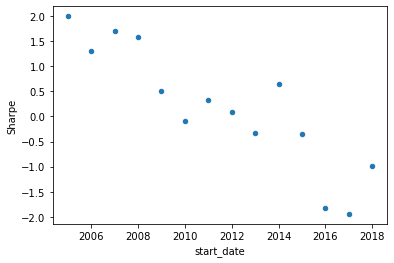

In [17]:
results_tc[['start_date', 'Sharpe']].plot(kind='scatter', x='start_date', y='Sharpe')

<AxesSubplot:>

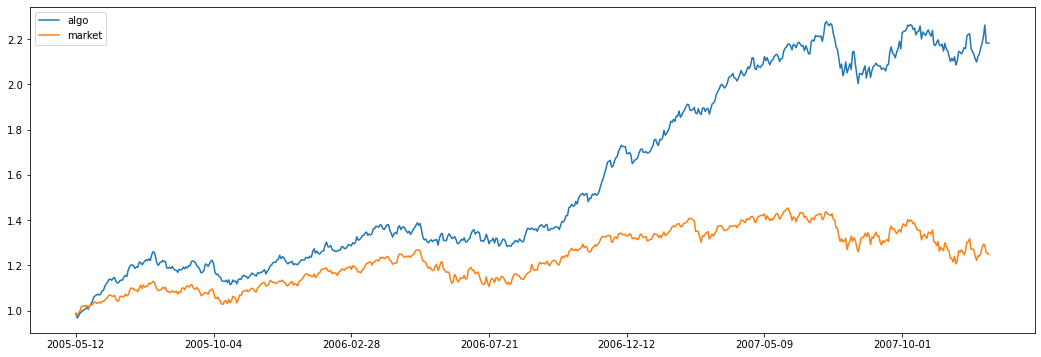

In [9]:
returns = pd.concat([all_cumret_tc[2005], market_cumret[2005]], axis=1)
returns.columns = ['algo', 'market']
returns.plot(figsize=(18,6))

<AxesSubplot:>

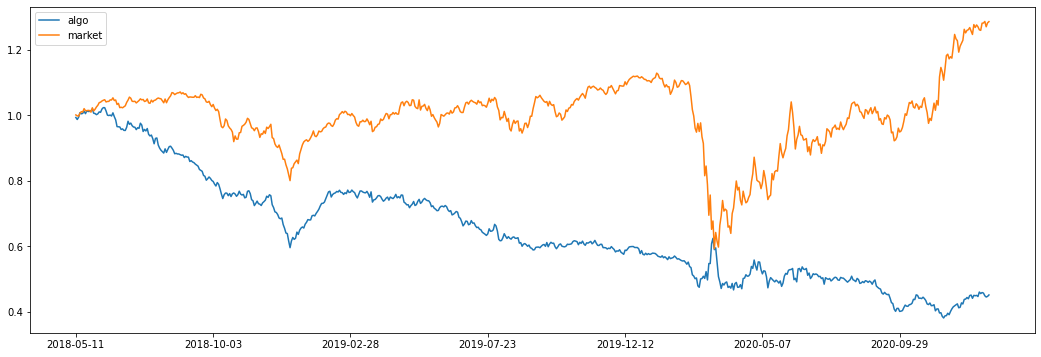

In [10]:
returns = pd.concat([all_cumret_tc[2018], market_cumret[2018]], axis=1)
returns.columns = ['algo', 'market']
returns.plot(figsize=(18,6))